In [1]:
%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
#np.seterr(all='ignore')
from threeML import *

Configuration read from /Users/jburgess/.threeML/threeML_config.yml


In [2]:
triggerName = 'bn090217206'
ra = 204.9
dec = -8.4

#Data are in the current directory

datadir = os.path.abspath('.')


#The .pha, .bak and .rsp files have been prepared with the Fermi
#official software. In the future it will be possible to create
#them directly from the plugin

#Create an instance of the GBM plugin for each detector
#Data files
obsSpectrum = os.path.join( datadir, "bn090217206_n6_srcspectra.pha{1}" )
bakSpectrum = os.path.join( datadir, "bn090217206_n6_bkgspectra.bak{1}" )
rspFile     = os.path.join( datadir, "bn090217206_n6_weightedrsp.rsp{1}" )

#Plugin instance
NaI6 = OGIPLike( "NaI6", obsSpectrum, bakSpectrum, rspFile )

#Choose energies to use (in this case, I exclude the energy
#range from 30 to 40 keV to avoid the k-edge, as well as anything above
#950 keV, where the calibration is uncertain)
NaI6.set_active_measurements( "10.0-30.0", "40.0-950.0" )

#Now repeat for the other GBM detectors

obsSpectrum = os.path.join( datadir, "bn090217206_n9_srcspectra.pha{1}" )
bakSpectrum = os.path.join( datadir, "bn090217206_n9_bkgspectra.bak{1}" )
rspFile     = os.path.join( datadir, "bn090217206_n9_weightedrsp.rsp{1}" )
#Plugin instance
NaI9 = OGIPLike( "NaI9", obsSpectrum, bakSpectrum, rspFile )
#Choose chanels to use
NaI9.set_active_measurements( "10.0-30.0", "40.0-950.0" )


obsSpectrum = os.path.join( datadir, "bn090217206_b1_srcspectra.pha{1}" )
bakSpectrum = os.path.join( datadir, "bn090217206_b1_bkgspectra.bak{1}" )
rspFile     = os.path.join( datadir, "bn090217206_b1_weightedrsp.rsp{1}" )
#Plugin instance
BGO1 = OGIPLike( "BGO1", obsSpectrum, bakSpectrum, rspFile )
#Choose chanels to use (in this case, from 200 keV to 10 MeV)
BGO1.set_active_measurements( "200-10000" )


data_list = DataList( NaI6, NaI9, BGO1 )


WARNING UserWarning: Field 6 has a repeat count of 0 in its format code, indicating an empty field.


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum EBOUNDS energy



Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 10.0-30.0 translates to channels 4-20
Range 40.0-950.0 translates to channels 26-125
Now using 117 channels out of 128
Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 10.0-30.0 translates to channels 6-21
Range 40.0-950.0 translates to channels 27-125
Now using 115 channels out of 128
Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 200-10000 translates to channels 2-89
Now using 88 channels out of 128



WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum EBOUNDS energy



In [3]:
#Let's use a Band model, a phenomenological model typically used for GRB

bb= Blackbody()

pl  = Powerlaw()

comp_model = bb+pl


band = Band()




In [4]:
GRB = PointSource( triggerName, ra, dec, spectral_shape=comp_model )

model = Model( GRB )

jl = JointLikelihood( model, data_list )

res = jl.fit()


GRB2 = PointSource( triggerName+'_band', ra, dec, spectral_shape=band )

model2 = Model( GRB2 )

jl2 = JointLikelihood( model2, data_list )

res2 = jl2.fit()


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: divide by zero encountered in log



Best fit values:



,Value,Unit
bn090217206.spectrum.main.composite.K_1,(1.61 +/- 0.18) x 10^-6,1 / (cm2 keV3 s)
bn090217206.spectrum.main.composite.kT_1,(7.94 +/- 0.28) x 10,keV
bn090217206.spectrum.main.composite.K_2,6.3 +/- 0.5,1 / (cm2 keV s)
bn090217206...index_2,-1.488 +/- 0.017,



Correlation matrix:



1.00,-0.95,-0.41,0.28
-0.95,1.00,0.50,-0.46
-0.41,0.50,1.00,-0.92
0.28,-0.46,-0.92,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
BGO1,623.929841
NaI6,854.570183
NaI9,767.391170
total,2245.891193



WARNING RuntimeWarning: divide by zero encountered in log



Best fit values:




WARNING UserWarning: 51.46 percent of samples have been thrown away because they failed the constraints on the parameters. This results might not be suitable for error propagation. Enlarge the boundaries until you loose less than 1 percent of the samples.



,Value,Unit
bn090217206_band.spectrum.main.Band.K,(1.80 +/- 0.05) x 10^-2,1 / (cm2 keV s)
bn090217206_band...alpha,(-8.02 +/- 0.27) x 10^-1,
bn090217206_band.spectrum.main.Band.xp,(6.01 +/- 0.31) x 10^2,keV
bn090217206_band.spectrum.main.Band.beta,-5.00 +/- 0.20,



Correlation matrix:



1.00,0.69,-0.92,0.02
0.69,1.00,-0.78,0.01
-0.92,-0.78,1.00,-0.04
0.02,0.01,-0.04,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
BGO1,579.088399
NaI6,824.220440
NaI9,732.669751
total,2135.978590


<IPython.core.display.Javascript object>


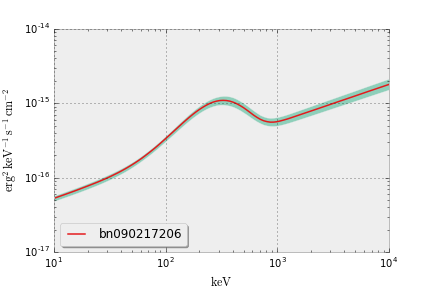

In [5]:
#spec_plot_mle = SpectralPlotter(jl)

plot_point_source_spectra(jl.results,
                          flux_unit='erg2/(cm2 s keV)')


<IPython.core.display.Javascript object>


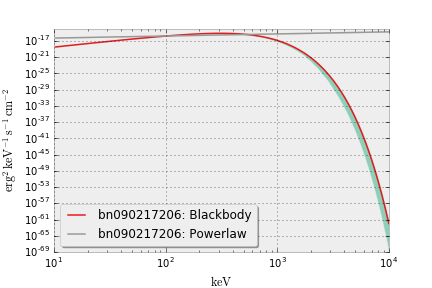

In [6]:
plot_point_source_spectra(jl.results,
                          use_components=True,
                          equal_tailed=False,
                          best_fit='median',
                          flux_unit='erg2/(cm2 s keV)')



<IPython.core.display.Javascript object>


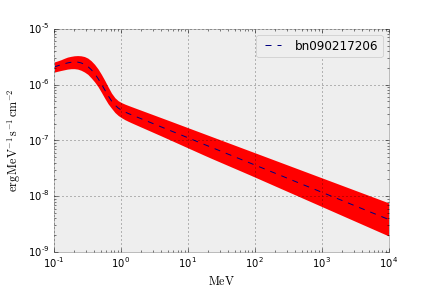

In [7]:
plot_point_source_spectra(jl.results,
                          energy_unit='MeV',
                          ene_min=1e-1,
                          ene_max=1e4,
                          fit_cmap='jet',
                          contour_cmap='rainbow_r',
                          confidence_level=.99,
                          flux_unit='erg/(cm2 s MeV)',
                          legend_kwargs={'loc':'upper right'},
                          plot_style_kwargs={'linestyle':'--'},
                          contour_style_kwargs={'lw':0}
                         )






<IPython.core.display.Javascript object>


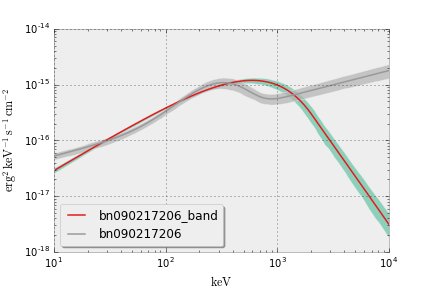

In [8]:

plot_point_source_spectra(jl.results,
                          jl2.results,
                          confidence_level=.90,
                          equal_tailed=False,
                          flux_unit='erg2/(cm2 s keV)')



<IPython.core.display.Javascript object>


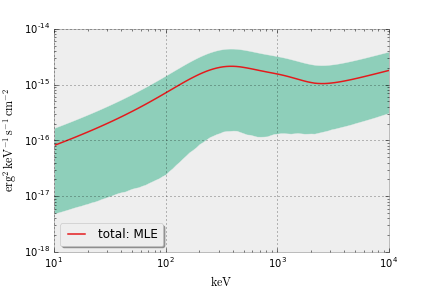

In [9]:

plot_point_source_spectra(jl.results,
                          jl2.results,
                          confidence_level=0.68,
                          sum_sources=True,
                          flux_unit='erg2/(cm2 s keV)')

In [5]:
comp_model.K_1.prior = Log_uniform_prior(lower_bound = 1E-7, upper_bound = 1E-5)
comp_model.K_2.prior = Log_uniform_prior(lower_bound =1E-1,upper_bound = 1E2)
comp_model.index_2.set_uninformative_prior(Uniform_prior)
comp_model.kT_1.prior = Log_uniform_prior(lower_bound =1E1,upper_bound = 1E4)

bayes = BayesianAnalysis(model, data_list)

res= bayes.sample(20,100,500)



band.K.prior = Log_uniform_prior(lower_bound = 1E-3, upper_bound = 1)
band.xp.prior =Log_uniform_prior(lower_bound = 10, upper_bound = 700) 
band.alpha.set_uninformative_prior(Uniform_prior)
band.beta.set_uninformative_prior(Uniform_prior)


bayes2 = BayesianAnalysis(model2, data_list)

res2= bayes2.sample(20,100,500)


Mean acceptance fraction: 0.5794

Maximum a posteriori probability (MAP) point:



,Value,Unit
bn090217206.spectrum.main.composite.K_1,(1.61 -0.16 +0.21) x 10^-6,1 / (cm2 keV3 s)
bn090217206.spectrum.main.composite.kT_1,(7.94 -0.29 +0.26) x 10,keV
bn090217206.spectrum.main.composite.K_2,6.30 -0.5 +0.30,1 / (cm2 keV s)
bn090217206...index_2,-1.490 -0.013 +0.021,



Values of -log(posterior) at the minimum:



,-log(posterior)
BGO1,-620.587144
NaI6,-851.538653
NaI9,-764.490675
total,-2236.616472



Mean acceptance fraction: 0.5524

Maximum a posteriori probability (MAP) point:



,Value,Unit
bn090217206_band.spectrum.main.Band.K,(1.80 -0.04 +0.05) x 10^-2,1 / (cm2 keV s)
bn090217206_band...alpha,(-8.03 -0.24 +0.29) x 10^-1,
bn090217206_band.spectrum.main.Band.xp,(6.04 -0.35 +0.25) x 10^2,keV
bn090217206_band.spectrum.main.Band.beta,-4.64 -0.13 +1.3,



Values of -log(posterior) at the minimum:



,-log(posterior)
BGO1,-579.894174
NaI6,-825.481027
NaI9,-733.740692
total,-2139.115893


<IPython.core.display.Javascript object>


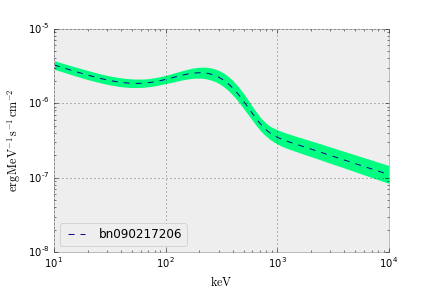

In [12]:
plot_point_source_spectra(bayes.results,
                          fit_cmap='plasma',
                          contour_cmap='winter',
                          confidence_level=0.9,
                          flux_unit='erg/(cm2 s MeV)',
                          legend_kwargs={'loc':'lower left'},
                          plot_style_kwargs={'linestyle':'--'},
                          contour_style_kwargs={'lw':0}
                         )

<IPython.core.display.Javascript object>


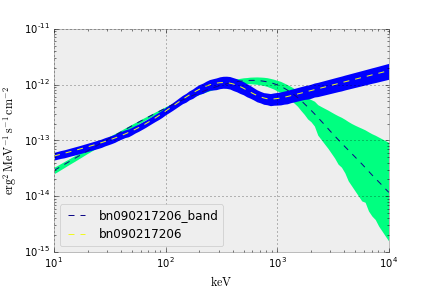

In [19]:
plot_point_source_spectra(bayes.results,bayes2.results,
                          fit_cmap='plasma',
                          equal_tailed=False,
                          contour_cmap='winter',
                          confidence_level=.95,
                          flux_unit='erg2/(cm2 s MeV)',
                          legend_kwargs={'loc':'lower left'},
                          plot_style_kwargs={'linestyle':'--'},
                          contour_style_kwargs={'lw':0}
                         )

<IPython.core.display.Javascript object>


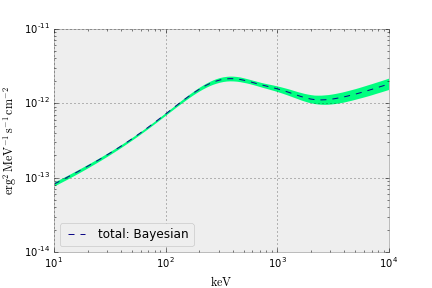

In [14]:
plot_point_source_spectra(bayes.results,bayes2.results,
                          fit_cmap='plasma',
                          contour_cmap='winter',
                          flux_unit='erg2/(cm2 s MeV)',
                          legend_kwargs={'loc':'lower left'},
                          plot_style_kwargs={'linestyle':'--'},
                          contour_style_kwargs={'lw':0},
                          sum_sources=True
                         )

<IPython.core.display.Javascript object>


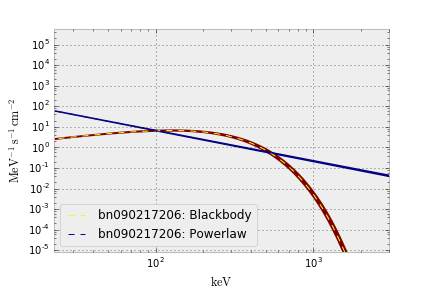

In [15]:
plot_point_source_spectra(bayes.results,
                          fit_cmap='plasma_r',
                          contour_cmap='jet_r',
                          use_components=True,
                          flux_unit='1/(cm2 s MeV)',
                          legend_kwargs={'loc':'lower left'},
                          plot_style_kwargs={'linestyle':'--'},
                          contour_style_kwargs={'lw':0},
                         )

<IPython.core.display.Javascript object>


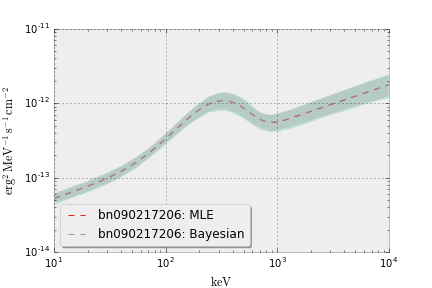

In [18]:
plot_point_source_spectra(bayes.results,jl.results,
                          confidence_level=.95,
                          equal_tailed=False,
                          flux_unit='erg2/(cm2 s MeV)',
                          plot_style_kwargs={'linestyle':'--'},
                          contour_style_kwargs={'lw':1,'linestyle':':','alpha':0.4},
                          fraction_of_samples=.01
                         )

<IPython.core.display.Javascript object>


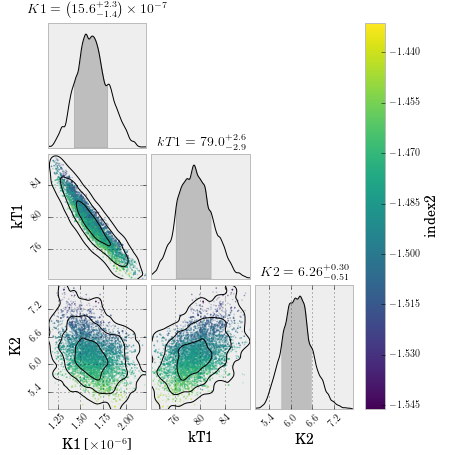

In [6]:
_=bayes.corner_plot_cc(color_params='index2')